# [Makie](https://docs.makie.org/stable/) hands on

* Plotting framework written mostly in Julia
* Multiple backends for optimal support of Desktop (GLMakie), Publications (CairoMakie), Web (WGLMakie), Ray Tracing (RPRMakie, experimental)
* 2D, 3D, animations, interactive visualizations

From https://juliadatascience.io:

![](https://user-images.githubusercontent.com/1010467/210597867-b4638e18-a6f1-4174-bb68-6c9f20485b66.png)


![](https://user-images.githubusercontent.com/1010467/210597895-78183204-f7ad-4645-82b2-1c8f859a178b.png)


# [GLMakie](https://docs.makie.org/v0.19.1/documentation/backends/glmakie/index.html)

* the first backend and the most feature complete
* uses the GPU via OpenGL for big 3D animations
* Basic UI elements for simple Dashboards
* Needs a GPU, [or a virtual GPU (e.g. Mesa, VirtualGL)](https://docs.makie.org/v0.19.1/documentation/headless/index.html#glmakie)

# [CairoMakie](https://docs.makie.org/v0.19.1/documentation/backends/cairomakie/index.html)

* Best 2D rendering quality 
* Can export SVGs, PDFs, etc
* 3D support experimental
* Not interactive (but can still be used for animations etc)
* runs everywhere on the CPU

# [WGLMakie](https://docs.makie.org/v0.19.1/documentation/backends/wglmakie/index.html)

* creates visualizations via threejs & webgl in the browser
* Similar to GLMakie, but less mature
* Can be fast for visualizing large data, but has an overhead for transfering data to browser
* Mostly feature complete, with some things still missing (marker stroke, line joints)
* runs almost everywhere on the GPU
* great for working on remote machines or in notebooks

# [RPRMakie](https://docs.makie.org/v0.19.1/documentation/backends/rprmakie/index.html)

* newest, supports only a subset of Makie (mostly the 3d primitives)
* only runs on linux + windows right now
* very slow, needs highend hardware for high quality animations
* still has lots of bugs
* BUT: looks amazing when it works :)


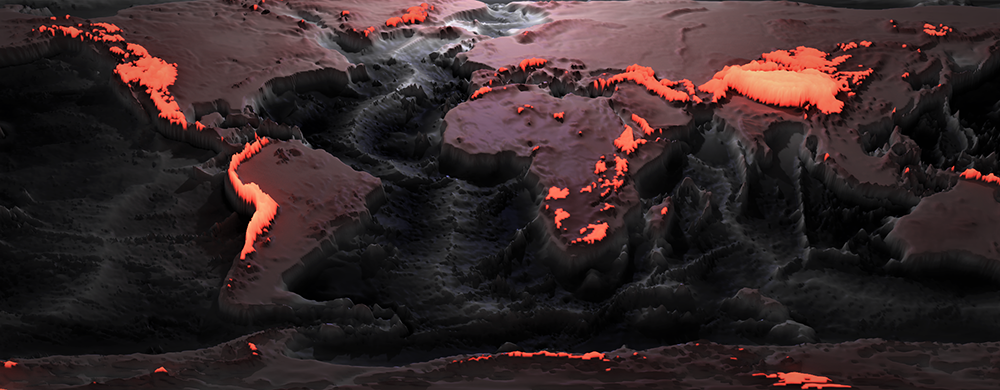
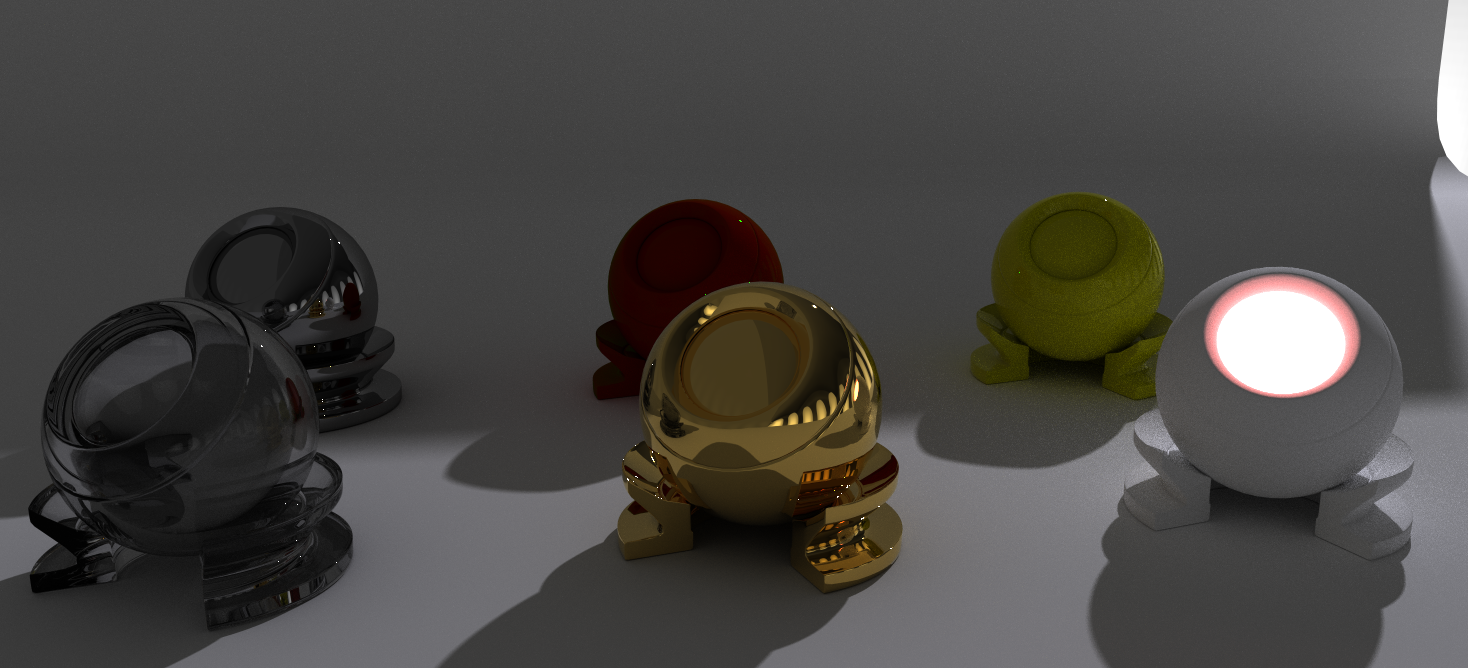

# WGLMakie & JSServe Dashboards

In [ ]:
"julia@$(VERSION)"

In [ ]:
import Pkg; Pkg.activate("../."); Pkg.status()

# Animate visualization from [CliMA](https://github.com/CliMA/ClimaCore.jl/blob/main/lib/ClimaCoreMakie/examples/file.jl)

In [ ]:
using WGLMakie, Makie, ClimaCoreMakie, GeoMakie
WGLMakie.activate!() # activate a backend
# Utility to create plots + data
include("clima-plot.jl"); # Visualization from CliMA

In [ ]:
# Page() # optional for resseting the JavaScript state of the notebook 

# Inputs to the visualization
time_series = load_time_series() # use load_time_series(n) with n < 9 if running out of ram
projection = Observable("+proj=wink2")
field = Observable("temperature")
time = Observable(5)
level = Observable(1)
overlay_toggle = Observable(true)

fig = Figure(resolution=(1300, 600))
simulation_plot(fig, time_series, projection, field, time, level, overlay_toggle)
fig

In [ ]:
time[] = 9
level[] = 4
field[] = "kinetic_energy";

### Quick start with Observables

* Makie & JSServe and some other packages all use [Observables.jl](https://github.com/JuliaGizmos/Observables.jl) for interactions

In [ ]:
# Observable is re-exported from Makie + JSServe
observable = Observable(1)
# creates a new observables applying f everytime any `observables` updates
plus_1 = map(x-> x + 1, observable)
# `on(f, observable)`, call `f` whenever `observable` changes
square = Observable(plus_1[]) # obs[] gets the value
on(plus_1) do value
    square[] = value ^ 2 # same as `square = map(x-> x^2, plus_1)`
end
obs = Observable(100) 
connect!(obs, plus_1); # Forward all updates/values from obs2 to obs1

### Quick start with JSServe

In [ ]:
using JSServe
# DOM lets you create any HTML element in Julia
# E.g.: DOM.div, DOM.span, DOM.script, DOM.image, ...
# Styling + Attributes works almost the same as in HTML:
bold(x) = DOM.span(x; style="font-weight: bold")

# DOM works with Observables, either by passing an observable as argument/attribute or by creating `Observable(DOM.div(...))`
JSServe.App() do
    s = JSServe.Slider(1:5) # Predefined widgets generating the correct HTML output + Julia connection
    connect!(observable, s.value)
    return DOM.div(s, "observable: ", bold(observable), ", plus_1: ", bold(plus_1), ", connected: ", bold(obs), ", square: ", bold(square))
end

### Update Observables from wherever you want!

* visualization + UI are separated
* you can use anything you see fit, including other UI libraries like GTK, QT, etc

In [ ]:
App() do
    projection = Observable("+proj=wink2")
    field = Observable("temperature")
    time = Observable(5)
    level = Observable(1)
    overlay_toggle = Observable(true)

    simulation = Figure(resolution=(1300, 600))
    simulation_plot(simulation, time_series, projection, field, time, level, overlay_toggle)
    
    # Make a Makie widget
    fig = Figure(resolution=(200, 100), backgroundcolor=:lightgray)
    ms = Makie.Slider(fig[1, 1], range=1:9)
    # and JSServe widget
    js = JSServe.Slider(1:nlevels(time_series))
    connect!(level, js.value)
    connect!(time, ms.value)
    # You can insert a Makie.Figure/Scene into the DOM, wherever you want!
    return DOM.div(js, fig, simulation)
end

### Why would I use JSServe UI
* Wide range of widgets & Javascript Libraries
* HTML widgets much more customizable and mature
* To integrate dashboards into web pages
* Can put together fairly complex JavaScript interactions, which stay interactive on web pages without a Julia server

### Why not

* WGLMakie is not as fast and feature complete as GLMakie
* Must run in Browser or Electron
* There is no way around paying the cost of serializing your data and sending it to JS (besides writing it in JS)

In [ ]:
sproj = ["wink2", "wintri", "poly", "qua_aut", "rouss", "rpoly", "sinu"]

App() do
    time_s = JSServe.Slider(1:length(time_series))
    level_s = JSServe.Slider(1:nlevels(time_series))
    fields = collect(string.(propertynames(time_series[1])))
    field_d = JSServe.Dropdown(fields)
    projection_d = JSServe.Dropdown(sproj)
    complete_projection = map(x-> "+proj=" * x, projection_d.option)
    overlay_c = JSServe.Checkbox(true)
    # connect!(projection, complete_projection)
    # connect!(field, field_d.option)
    # connect!(time, time_s.value)
    # connect!(level, level_s.value)
    # connect!(overlay_toggle, overlay_c.value)
    fig = Figure(resolution=(1200, 700))
    simulation_plot(fig, time_series, complete_projection, field_d.option, time_s.value, level_s.value, overlay_c.value)
    
    return DOM.div(time_s, level_s, field_d, projection_d, overlay_c, fig)
end

### Styling & Layout

In [ ]:
JSServe.TailwindCSS

In [ ]:
# Just create functions returning styled HTML

function widget_container(title, widget; class="")
    return DOM.div(JSServe.TailwindCSS, title, widget, class="flex-row, mb-1 mt-1 $class")
end

function title(name; class="")
    return DOM.h2(name; class="font-semibold $class")
end

function slider(name, values; class="")
    s = JSServe.Slider(values; class="", style="width: 100%;")
    t = title(DOM.div(name, DOM.div(s.value; class="float-right")))
    return s, widget_container(t, s; class)
end

App() do
    s, div = slider("Time: ", 1:9)
    # do something with s.value ...
    return DOM.div(div, class="w-48")
end

In [ ]:
# Create a type & overload `JSServe.jsrender`
struct StyledSlider
    slider::JSServe.Slider
    div::JSServe.Node
end

function StyledSlider(name, values)
    s, div = slider(name, values; class="")
    return StyledSlider(s, div)
end

function JSServe.jsrender(session::Session, slider::StyledSlider)
    return JSServe.jsrender(session, slider.div)
end

App() do 
    s = StyledSlider("Time:", 1:9)
    return DOM.div(s, class="w-48")
end

In [ ]:
include("widgets.jl")
sproj = ["wink2", "wintri", "poly", "qua_aut", "rouss", "rpoly", "sinu"]

app = App() do
    time, tdiv = D.Slider("Time:", 1:length(time_series))
    time.value[] = 5
    level, ldiv = D.Slider("Level:", 1:nlevels(time_series))
    fields = collect(string.(propertynames(time_series[1])))
    field, fdiv = D.Dropdown("Field:", fields)
    projection, pdiv = D.Dropdown("Projection:", sproj)
    projection_compl = map(x-> "+proj=" * x, projection.option)
    overlay, odiv = D.Checkbox("Earth overlay:", true)
    menu = D.ColList(fdiv, pdiv, odiv, tdiv, ldiv)
    fig = Figure(resolution=(1200, 700))
    simulation_plot(fig, time_series, projection_compl, field.option, time.value, level.value, overlay.value)
    return D.RowList(D.Card(menu), D.Card(fig))
end

## Exporting Apps

In [ ]:
isdefined(Main, :server) && close(server)
server = JSServe.Server(app, "0.0.0.0", 7894)
server.proxy_url = "http://127.0.0.1:8888/proxy/$(server.port)"
App(DOM.a("click me", href=JSServe.online_url(server, "")))

In [ ]:
# export_static(folder::String, routes::Routes)
# export_static(folder::String, app::App)
routes = JSServe.Routes()
routes["earth"] = app
routes["/"] = App(DOM.a("click me", href="/earth.html"))
JSServe.export_static("static-export", routes)

### Exporting static

* no running Julia process
* So everything relying on Julia will freeze
* Only things written in JavaScript will stay interactive

### Interactivity by caching all states 

In [ ]:
interactive = App() do session::Session
    n = 10
    index_slider = JSServe.Slider(1:n)
    volume = rand(n, n, n)
    slice = map(index_slider) do idx
        return volume[:, :, idx]
    end
    fig = Figure()
    ax, cplot = contour(fig[1, 1], volume)
    rectplot = linesegments!(ax, Rect(-1, -1, 12, 12), linewidth=2, color=:red)
    on(index_slider) do idx
        translate!(rectplot, 0,0,idx)
    end
    heatmap(fig[1, 2], slice)
    slider = DOM.div("z-index: ", index_slider, index_slider.value)
    return JSServe.record_states(session, DOM.div(slider, fig))
end
JSServe.export_static("cached-export", interactive)